### This notebook requires the modified version of dask-glm with the [PR #89](https://github.com/dask/dask-glm/pull/89)

```
0. pip install git+https://github.com/dask/dask
1. git clone https://github.com/daxiongshu/dask-glm
2. cd dask-glm
3. git checkout allow_lbfgs_with_cupy
4. pip install -e .
```

In [ ]:
import os
GPU_id = '0,1,2,3,4,5,6,7'
os.environ['CUDA_VISIBLE_DEVICES'] = GPU_id
os.environ["CUPY_EXPERIMENTAL_SLICE_COPY"] = "1"
num_gpus = len(GPU_id.split(','))

In [2]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import time
from tqdm import tqdm
import numpy as np

import cudf as gd
import cupy as cp
import subprocess

import dask
import dask_cudf
import dask.array as da
from dask import delayed,compute,persist

from dask_glm.estimators import LogisticRegression
from dask_glm.datasets import make_classification as make_classification
from dask_glm.datasets import make_regression
import dask_glm.algorithms

from dask_glm.families import Logistic
from dask_glm.regularizers import Regularizer


from dask.distributed import Client, wait, LocalCluster
from dask_cuda import LocalCUDACluster


print('cudf',gd.__version__)
print('dask_cudf',dask_cudf.__version__)
print('dask',dask.__version__)
print('cupy',cp.__version__)

cudf 0.16.0
dask_cudf 0.16.0
dask 2.30.0+46.ge4bdfcf5
cupy 8.0.0


In [3]:
cmd = "hostname --all-ip-addresses"
process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]

cluster = LocalCUDACluster(ip=IPADDR,protocol="ucx", 
                           #rmm_pool_size="31GB",
                           enable_tcp_over_ucx=True, enable_nvlink=True)
client = Client(cluster)
client

Client Scheduler: ucx://10.33.227.161:53957 Dashboard: http://10.33.227.161:8787/status,Cluster Workers: 8 Cores: 8 Memory: 1.08 TB


### helper functions

In [4]:
def to_cupy(X, y):
    X = X.map_blocks(lambda x: cp.asarray(x),
                         dtype=X.dtype, meta=cp.asarray(X._meta))
    y = y.map_blocks(lambda x: cp.asarray(x),
                     dtype=y.dtype, meta=cp.asarray(y._meta))
    return X,y

### Dask GLM with cupy accuracy check

In [5]:
N = 200000
p = 100
chunks = num_gpus
dx, dy = make_classification(n_samples=N, n_features=p, n_informative=10, chunksize=N//chunks)
dx, dy = to_cupy(dx, dy)

In [6]:
print(dx.shape,dy.shape)
print(type(dx),type(dy))
print(dx.dtype, dy.dtype)

(200000, 100) (200000,)
<class 'dask.array.core.Array'> <class 'dask.array.core.Array'>
float64 bool


In [7]:
dx, dy = persist(dx, dy)
dx.compute_chunk_sizes()

dask.array<lambda, shape=(200000, 100), dtype=float64, chunksize=(25000, 100), chunktype=cupy.ndarray>

In [8]:
%%time
lr = LogisticRegression(solver='admm', max_iter=5)
lr.fit(dx,dy)
yp = lr.predict(dx)
print("accuracy",da.mean(yp==dy).compute())

accuracy 0.746875
CPU times: user 869 ms, sys: 158 ms, total: 1.03 s
Wall time: 3.43 s


In [9]:
%%time
solvers = ['admm', 'lbfgs', 'newton', 'proximal_grad', 'gradient_descent']
for s in solvers:
    lr = LogisticRegression(solver=s, max_iter=5)
    lr.fit(dx,dy)
    yp = lr.predict(dx)
    print(s,"accuracy",da.mean(yp==dy).compute())

admm accuracy 0.746875
lbfgs accuracy 0.747015
newton accuracy 0.74689
proximal_grad accuracy 0.74697
gradient_descent accuracy 0.74697
CPU times: user 8.86 s, sys: 909 ms, total: 9.77 s
Wall time: 15.5 s


### Speedup Test

In [10]:
def get_run_time(solver,min_samples,max_samples,data_type='cupy'):
    times = []
    for n in range(min_samples,max_samples+1):
        n_samples=10**n
        n_features = 20
        chunks = num_gpus if data_type=='cupy' else 80 # dgx-1 has 40 cores and 80 hyperthreads
        
        dx, dy = make_classification(n_samples=n_samples, n_features=n_features, n_informative=10, chunksize=n_samples//chunks)
        #dx = dx.astype('float32')
        if data_type=='cupy':
            dx, dy = to_cupy(dx, dy)
        dx, dy = persist(dx, dy)
        wait(dx)
        wait(dy)
        start = time.time()
        lr = LogisticRegression(solver=solver, max_iter=2)
        lr.fit(dx,dy)
        duration = time.time()-start
        del dx,dy
        del lr
        times.append(duration)
        print('%s samples:10^%d time:%.2f'%(solver,n,duration))
    return times

#### dask glm with cupy on GPUs

In [11]:
%%time
solvers = ['admm', 'lbfgs', 'newton', 'proximal_grad', 'gradient_descent']
cupy_time = {}
for s in solvers:
    cupy_time[s] = get_run_time(s,3,8,data_type='cupy')

admm samples:10^3 time:0.34
admm samples:10^4 time:0.52
admm samples:10^5 time:0.32
admm samples:10^6 time:1.04
admm samples:10^7 time:0.50
admm samples:10^8 time:2.29
lbfgs samples:10^3 time:0.69
lbfgs samples:10^4 time:0.85
lbfgs samples:10^5 time:0.66
lbfgs samples:10^6 time:0.70
lbfgs samples:10^7 time:0.88
lbfgs samples:10^8 time:3.35
newton samples:10^3 time:0.81
newton samples:10^4 time:0.66
newton samples:10^5 time:0.97
newton samples:10^6 time:0.75
newton samples:10^7 time:0.94
newton samples:10^8 time:2.44
proximal_grad samples:10^3 time:1.27
proximal_grad samples:10^4 time:1.72
proximal_grad samples:10^5 time:1.74
proximal_grad samples:10^6 time:2.14
proximal_grad samples:10^7 time:2.71
proximal_grad samples:10^8 time:8.19
gradient_descent samples:10^3 time:1.22
gradient_descent samples:10^4 time:1.37
gradient_descent samples:10^5 time:1.58
gradient_descent samples:10^6 time:1.83
gradient_descent samples:10^7 time:2.51
gradient_descent samples:10^8 time:6.10
CPU times: user 

#### dask glm cpu baseline

In [12]:
# dask glm cpu baseline
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:37941 Dashboard: http://127.0.0.1:32903/status,Cluster Workers: 10 Cores: 80 Memory: 1.08 TB


In [13]:
%%time
solvers = ['admm', 'lbfgs', 'newton', 'proximal_grad', 'gradient_descent']
numpy_time = {}
for s in solvers:
    numpy_time[s] = get_run_time(s,3,8,data_type='numpy')

admm samples:10^3 time:1.53
admm samples:10^4 time:1.32
admm samples:10^5 time:3.49
admm samples:10^6 time:6.02
admm samples:10^7 time:15.93
admm samples:10^8 time:78.71
lbfgs samples:10^3 time:2.26
lbfgs samples:10^4 time:2.53
lbfgs samples:10^5 time:4.86
lbfgs samples:10^6 time:7.97
lbfgs samples:10^7 time:9.14
lbfgs samples:10^8 time:24.47
newton samples:10^3 time:3.03
newton samples:10^4 time:2.73
newton samples:10^5 time:8.10
newton samples:10^6 time:7.28
newton samples:10^7 time:10.26
newton samples:10^8 time:38.09
proximal_grad samples:10^3 time:9.49
proximal_grad samples:10^4 time:6.62
proximal_grad samples:10^5 time:13.40
proximal_grad samples:10^6 time:26.64
proximal_grad samples:10^7 time:32.78
proximal_grad samples:10^8 time:72.09
gradient_descent samples:10^3 time:6.43
gradient_descent samples:10^4 time:4.01
gradient_descent samples:10^5 time:7.52
gradient_descent samples:10^6 time:12.98
gradient_descent samples:10^7 time:21.64
gradient_descent samples:10^8 time:44.04
CPU 

In [14]:
import matplotlib.pyplot as plt

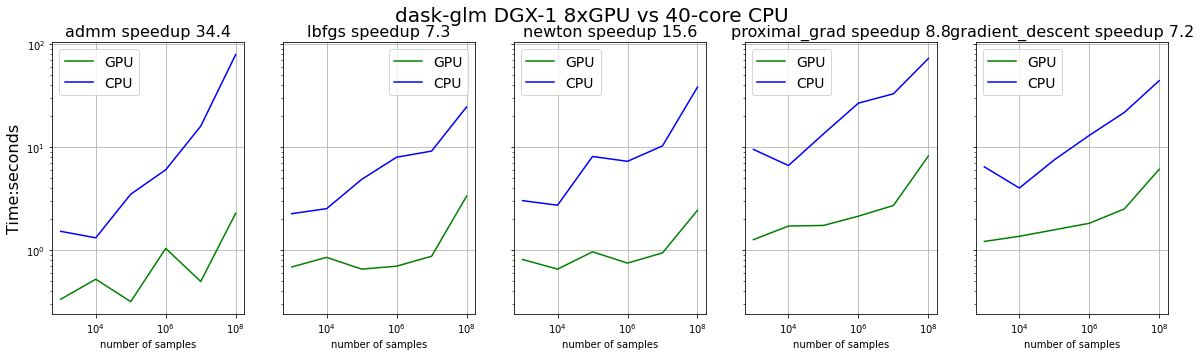

In [15]:
fig, axs = plt.subplots(1,5, figsize=(20, 5),sharex=True,sharey=True)
solvers = ['admm', 'lbfgs', 'newton', 'proximal_grad', 'gradient_descent']
speedup = [numpy_time[s][-1]/cupy_time[s][-1] for s in solvers]
nsamples = [10**i for i in range(3,9)]
axs[0].set_ylabel("Time:seconds",fontsize=16)
plt.suptitle("dask-glm DGX-1 8xGPU vs 40-core CPU", fontsize=20)

for c,s in enumerate(solvers):
    axs[c].plot(nsamples,cupy_time[s],color='g',label='GPU')
    axs[c].plot(nsamples,numpy_time[s],color='b',label='CPU')
    axs[c].set_xscale("log")
    axs[c].set_yscale("log")
    axs[c].grid()
    axs[c].set_title('%s speedup %.1f'%(s, speedup[c]),fontsize=16)
    axs[c].set_xlabel("number of samples",)
    axs[c].legend(fontsize=14)

plt.savefig("dask_glm_cupy_vs_numpy.pdf",format='pdf',quality=95)

In [16]:
print(cupy_time)

{'admm': [0.33559155464172363, 0.524461030960083, 0.31807518005371094, 1.0430881977081299, 0.49884533882141113, 2.286559820175171], 'lbfgs': [0.689110279083252, 0.8542847633361816, 0.6569817066192627, 0.7015044689178467, 0.8759558200836182, 3.347743511199951], 'newton': [0.8148186206817627, 0.6568856239318848, 0.966106653213501, 0.7513766288757324, 0.9435408115386963, 2.4416980743408203], 'proximal_grad': [1.267759084701538, 1.7166051864624023, 1.740882396697998, 2.1409173011779785, 2.7149884700775146, 8.188908100128174], 'gradient_descent': [1.2183287143707275, 1.3660573959350586, 1.5796546936035156, 1.8258943557739258, 2.51454496383667, 6.101024866104126]}


In [17]:
print(numpy_time)

{'admm': [1.5261013507843018, 1.3206887245178223, 3.4944725036621094, 6.024350881576538, 15.929607391357422, 78.70614266395569], 'lbfgs': [2.2621474266052246, 2.531238079071045, 4.859462738037109, 7.973659038543701, 9.138251781463623, 24.47417974472046], 'newton': [3.026705503463745, 2.7327449321746826, 8.103541612625122, 7.275075435638428, 10.264176368713379, 38.08971357345581], 'proximal_grad': [9.486053466796875, 6.622894763946533, 13.397969961166382, 26.641576290130615, 32.78219223022461, 72.08710932731628], 'gradient_descent': [6.43262505531311, 4.009201765060425, 7.519303321838379, 12.976767778396606, 21.63583517074585, 44.03650212287903]}
